In [6]:
import torch
# 数据的原始处理
from torchvision import transforms
# pytorch十分贴心的为我们直接准备了这个数据集
from torchvision import datasets
# 加载数据集的
from torch.utils.data import DataLoader
# 激活函数
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
# 准备数据
 
batch_size = 64
#我们拿到的图片是pillow,我们要把他转换成模型里能训练的tensor也就是张量的格式
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
 

In [11]:
class InceptionA(torch.nn.Module):
    def __init__(self, in_channels):
        super(InceptionA, self).__init__()
        # 16x1x1核        
        self.branch1x1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        # 16x1x1再24x5x5       
        self.branch5x5_1 = torch.nn.Conv2d(in_channels,16, kernel_size=1)
        self.branch5x5_2 = torch.nn.Conv2d(16, 24, kernel_size=5, padding=2)
        # 16x1x1再24x3x3再24x3x3        
        self.branch3x3_1 = torch.nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = torch.nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = torch.nn.Conv2d(24, 24, kernel_size=3, padding=1)
        # 先池化再24x1x1        
        self.branch_pool = torch.nn.Conv2d(in_channels, 24, kernel_size=1)
    def forward(self, x):
        # 16x1x1核 
        branch1x1 = self.branch1x1(x)
        # 16x1x1再24x5x5 
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        # 16x1x1再24x3x3再24x3x3
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)
        # 先平均池化再24x1x1
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        # 拼接   
        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        # dim=1即以通道为维度   
        return torch.cat(outputs, dim=1)
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(88, 20, kernel_size=5)
        self.incep1 = InceptionA(in_channels=10)
        self.incep2 = InceptionA(in_channels=20)
        self.mp = torch.nn.MaxPool2d(2)
        self.fc = torch.nn.Linear(1408, 10)
    def forward(self, x):
        in_size = x.size(0)
        # 输出通道为10        
        x = F.relu(self.mp(self.conv1(x)))
        # 输入通道10,incep1后输出通道为88=16+24+24+24        
        x = self.incep1(x)
        # 输出通道为20        
        x = F.relu(self.mp(self.conv2(x)))
        # 输入通道20,incep2后输出通道为88        
        x = self.incep2(x)
        x = x.view(in_size, -1)
        # 全链接        
        x = self.fc(x)
        return x
model = Net()
# 把计算迁移到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 20, kernel_size=(5, 5), stride=(1, 1))
  (incep1): InceptionA(
    (branch1x1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_pool): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incep2): InceptionA(
    (branch1x1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch3x3_1): Conv2d(20, 16, kernel_size=(1, 1), stride=(1, 1))
   

In [12]:
# 构造损失和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)# #lr为学习率

[1,   300] loss: 0.990
[1,   600] loss: 0.201
[1,   900] loss: 0.135
accuracy on test set: 96 % 
[2,   300] loss: 0.108
[2,   600] loss: 0.101
[2,   900] loss: 0.088
accuracy on test set: 97 % 
[3,   300] loss: 0.079
[3,   600] loss: 0.074
[3,   900] loss: 0.074
accuracy on test set: 98 % 
[4,   300] loss: 0.070
[4,   600] loss: 0.058
[4,   900] loss: 0.064
accuracy on test set: 98 % 
[5,   300] loss: 0.055
[5,   600] loss: 0.058
[5,   900] loss: 0.053
accuracy on test set: 98 % 
[6,   300] loss: 0.048
[6,   600] loss: 0.050
[6,   900] loss: 0.050
accuracy on test set: 98 % 
[7,   300] loss: 0.044
[7,   600] loss: 0.043
[7,   900] loss: 0.049
accuracy on test set: 98 % 
[8,   300] loss: 0.041
[8,   600] loss: 0.042
[8,   900] loss: 0.042
accuracy on test set: 98 % 
[9,   300] loss: 0.040
[9,   600] loss: 0.037
[9,   900] loss: 0.038
accuracy on test set: 98 % 
[10,   300] loss: 0.036
[10,   600] loss: 0.033
[10,   900] loss: 0.037
accuracy on test set: 98 % 


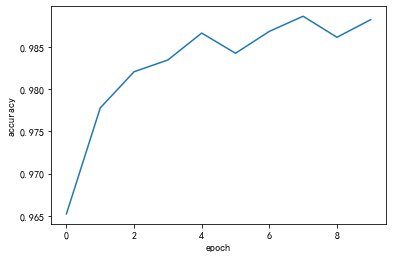

In [13]:
# 训练
 
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        #  正馈        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # 反馈        
        loss.backward()
        # 更新权重         
        optimizer.step()
        # 把损失加起来         
        running_loss += loss.item()
        #每300次输出一下数据
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
 
def test():
    correct = 0
    total = 0
    #不用算梯度    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # 我们取概率最大的那个数作为输出            
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total
 
 
if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()